In [126]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from graphviz import Digraph
from math import log2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import time
import networkx as nx

In [127]:
cardio_data = pd.read_csv('cardio_train.csv', sep=';').head(8000)

In [128]:
cardio_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [129]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
def data_preprocessing(data):
    # Edit On Dataset (Remove Dupilicates, Drop Id ,, Convert age into years instead of days)
    data = data.drop_duplicates()
    data = data.drop(columns=['id'])
    data['age'] = (data['age'] / 365).astype(int)
    

    # Try to Minimize the number of branches as possible
    age_bins = [0, 15, 30, 45, 60, 75, 90, 105, 120]  # Adjust max age if needed
    labels = ['0-15', '16-30', '31-45', '46-60', '61-75', '76-90', '91-105', '106-120']
    data['age'] = pd.cut(data['age'], bins=age_bins, labels=labels, right=False).astype(str)

    height_bins = [140, 150, 160, 170, 180, 190, 200]
    height_labels = ['140-150', '151-160', '161-170', '171-180', '181-190', '191-200']
    data['height'] = pd.cut(data['height'], bins=height_bins, labels=height_labels, right=False).astype(str)

    width_bins = [40, 50, 60, 70, 80, 90, 100]
    width_labels = ['40-50', '51-60', '61-70', '71-80', '81-90', '91-100']
    data['weight'] = pd.cut(data['weight'], bins=width_bins, labels=width_labels, right=False).astype(str)

    ap_hi_bins = [0, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]
    ap_hi_labels = ['0-80', '81-90', '91-100', '101-110', '111-120', '121-130', '131-140', '141-150', '151-160', '161-170', '171-180']
    data['ap_hi'] = pd.cut(data['ap_hi'], bins=ap_hi_bins, labels=ap_hi_labels, right=False).astype(str)

    ap_lo_bins = [0, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
    ap_lo_labels = ['0-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '111-120', '121-130', '131-140']
    data['ap_lo'] = pd.cut(data['ap_lo'], bins=ap_lo_bins, labels=ap_lo_labels, right=False).astype(str)

    # Handle Categorical data with Label Encoding
    le = LabelEncoder()
    categorical_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
    for col in categorical_cols:
        data[col] = le.fit_transform(data[col])
        
    return data


In [130]:
processed_data = data_preprocessing(cardio_data)

In [131]:
processed_data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,2,2,2,2,2,8,1,1,0,0,1,0
1,2,1,1,4,5,9,3,1,0,0,1,1
2,2,1,2,2,4,7,3,1,0,0,0,1
3,2,2,2,4,6,1,1,1,0,0,1,1
4,2,1,1,1,1,6,1,1,0,0,0,0


In [132]:
features= ['gender','cholesterol','gluc','smoke','alco','active','age', 'height','weight','ap_hi','ap_lo']
X = cardio_data[features]
y = cardio_data['cardio']

Processed_X = processed_data[features]
Processed_y = processed_data['cardio']

X.head()

,gender,cholesterol,gluc,smoke,alco,active,age,height,weight,ap_hi,ap_lo
0,2,1,1,0,0,1,18393,168,62.0,110,80
1,1,3,1,0,0,1,20228,156,85.0,140,90
2,1,3,1,0,0,0,18857,165,64.0,130,70
3,2,1,1,0,0,1,17623,169,82.0,150,100
4,1,1,1,0,0,0,17474,156,56.0,100,60


In [133]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
processed_x_train, processed_x_test, processed_y_train, processed_y_test = train_test_split(Processed_X, Processed_y, test_size=0.25, random_state=0)

In [134]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix , precision_recall_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
import seaborn as sns

In [135]:
def plot_confusion_matrix(y_true, y_pred, y_scores=None, classes=None, 
                          figsize=(12, 6), cmap='Blues', normalize=False, 
                          title=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if y_scores is not None:
        y_scores = np.array(y_scores)
        if y_scores.ndim > 1:
            y_scores = y_scores[:, 1] if y_scores.shape[1] == 2 else y_scores.ravel()

    if y_scores is not None and len(y_true) == len(y_scores):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(figsize[0]//2, figsize[1]))
        y_scores = None 
    
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm
        fmt = '.2f'
    else:
        fmt = 'd'
    
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, cbar=False, square=True,
                xticklabels=classes, yticklabels=classes, ax=ax1)
    ax1.set_xlabel('Predicted Label', fontsize=12)
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_title(title or ('Normalized Confusion Matrix' if normalize else 'Confusion Matrix'), 
                  fontsize=14, pad=20)
    
    if y_scores is not None:
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall, precision)
        
        ax2.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}', color='darkorange', lw=2)
        ax2.set_xlabel('Recall', fontsize=12)
        ax2.set_ylabel('Precision', fontsize=12)
        ax2.set_title('Precision-Recall Curve', fontsize=14, pad=20)
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.legend(loc='lower left')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
    
    plt.tight_layout()
    plt.savefig('confusion_matrix_with_pr_curve.png')
    plt.show()


In [136]:
# Hyperparameters for Decision Tree, Random Forest, and SVC
from sklearn.model_selection import GridSearchCV, cross_val_score

params_dt = {
    'max_depth': [2, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 50],
    'max_leaf_nodes': [10, 30, 50, 100, 200]
}
param_rd = {
    'n_estimators': [100, 200],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],    
    'max_features': ['sqrt', 'log2'], 
    'criterion': ['gini', 'entropy'],
}
svc_params = {
    'kernel' : ('poly', 'rbf'), 
    'C':[0.001, 0.01, 0.1, 0.5, 1, 10]
}

In [121]:
dt_grids = GridSearchCV(DecisionTreeClassifier(), param_grid=params_dt, cv=5).fit(processed_x_train, processed_y_train)
print("Best parameters for Decision Tree: ", dt_grids.best_params_)
print("Best score for Decision Tree: ", dt_grids.best_score_)

Best parameters for Decision Tree:  {'max_depth': 5, 'max_leaf_nodes': 100, 'min_samples_split': 50}
Best score for Decision Tree:  0.7273333333333334


In [122]:
dt_model = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=100, min_samples_split=50)
dt_model.fit(processed_x_train, processed_y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=100, min_samples_split=50)

In [123]:
dt_accuracy = accuracy_score(processed_y_test, dt_model.predict(processed_x_test))
print("Decision Tree Accuracy: ", dt_accuracy)

Decision Tree Accuracy:  0.7325


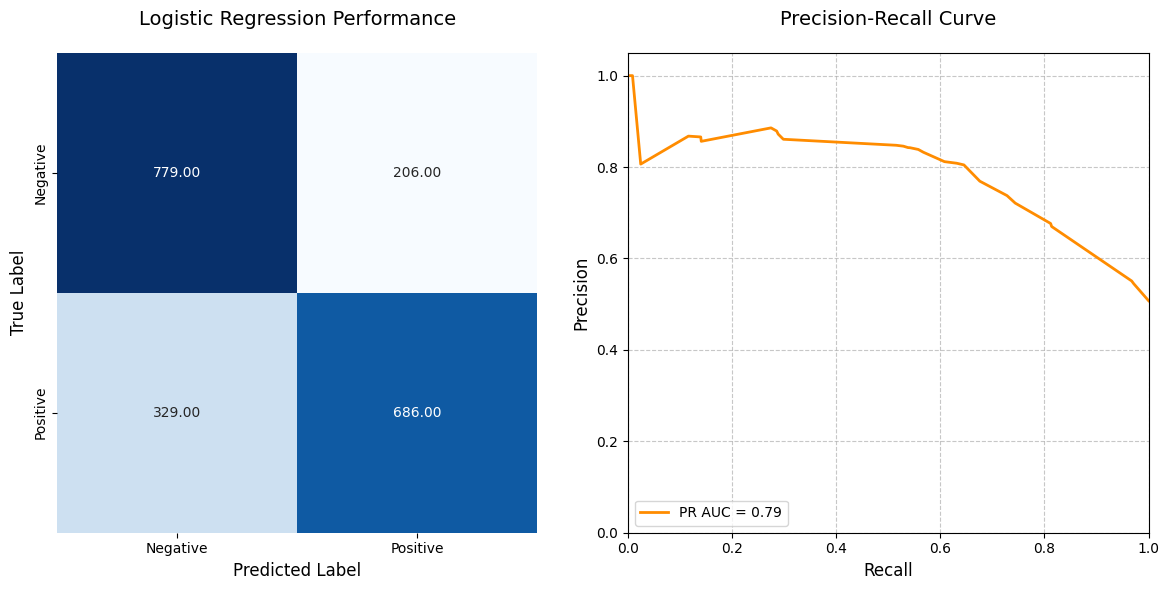

In [124]:
y_scores = dt_model.predict_proba(processed_x_test)[:, 1]
plot_confusion_matrix(y_true=processed_y_test, y_pred=dt_model.predict(processed_x_test), y_scores=y_scores, 
                        classes=['Negative', 'Positive'], normalize=True, 
                        title='Logistic Regression Performance')

In [137]:
svc_grids = GridSearchCV(SVC(), param_grid=svc_params, cv=5).fit(x_train, y_train)
print("Best parameters for SVC: ", svc_grids.best_params_)
print("Best score for SVC: ", svc_grids.best_score_)

Best parameters for SVC:  {'C': 10, 'kernel': 'poly'}
Best score for SVC:  0.6214999999999999


In [145]:
svc_model = SVC(kernel='poly', C=10, probability=True)
svc_model.fit(x_train, y_train)

SVC(C=10, kernel='poly', probability=True)

In [146]:
svc_accuracy = accuracy_score(y_test, svc_model.predict(x_test))
print("Support Vector Machine Accuracy: ", svc_accuracy)

Support Vector Machine Accuracy:  0.621


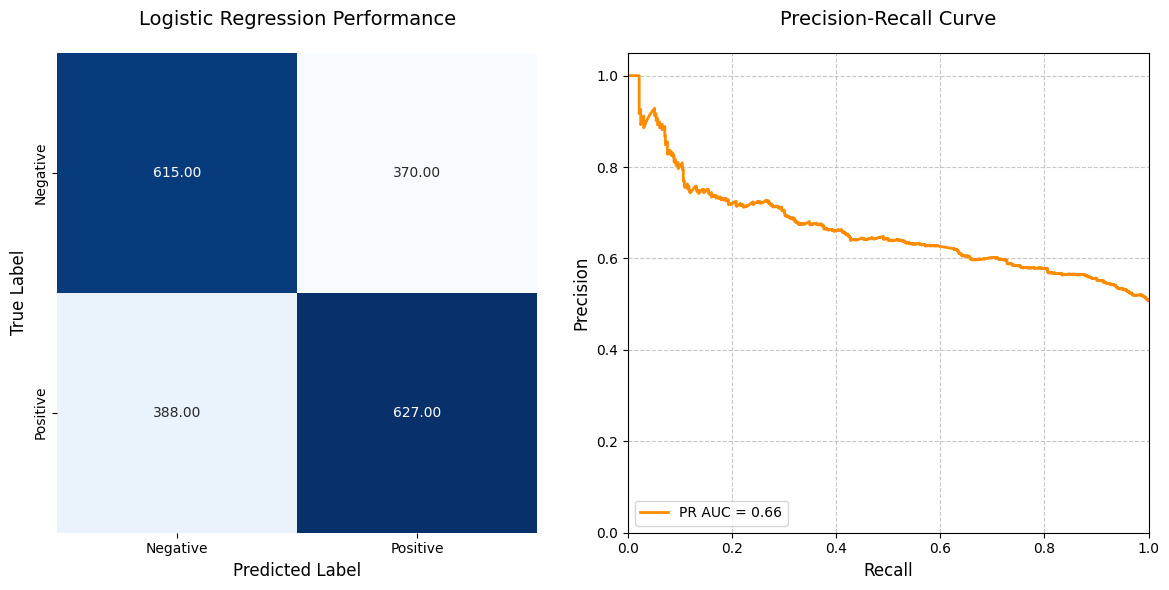

In [147]:
y_scores = svc_model.predict_proba(x_test)[:, 1]
plot_confusion_matrix(y_true=y_test, y_pred=svc_model.predict(x_test), y_scores=y_scores, 
                        classes=['Negative', 'Positive'], normalize=True, 
                        title='Logistic Regression Performance')

In [148]:
rf_grids = GridSearchCV(RandomForestClassifier(), param_grid=param_rd, cv=5, scoring='accuracy').fit(x_train, y_train)
print("Best parameters for Random Forest: ", rf_grids.best_params_)
print("Best score for Random Forest: ", rf_grids.best_score_)

Best parameters for Random Forest:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best score for Random Forest:  0.7318333333333333


In [152]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=2, min_samples_leaf=4, max_features='log2', criterion='gini')
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=4,
                       n_estimators=200)

In [154]:
rf_accuracy = accuracy_score(y_test, rf_model.predict(x_test))
print("Decision Tree Accuracy: ", rf_accuracy)

Decision Tree Accuracy:  0.743


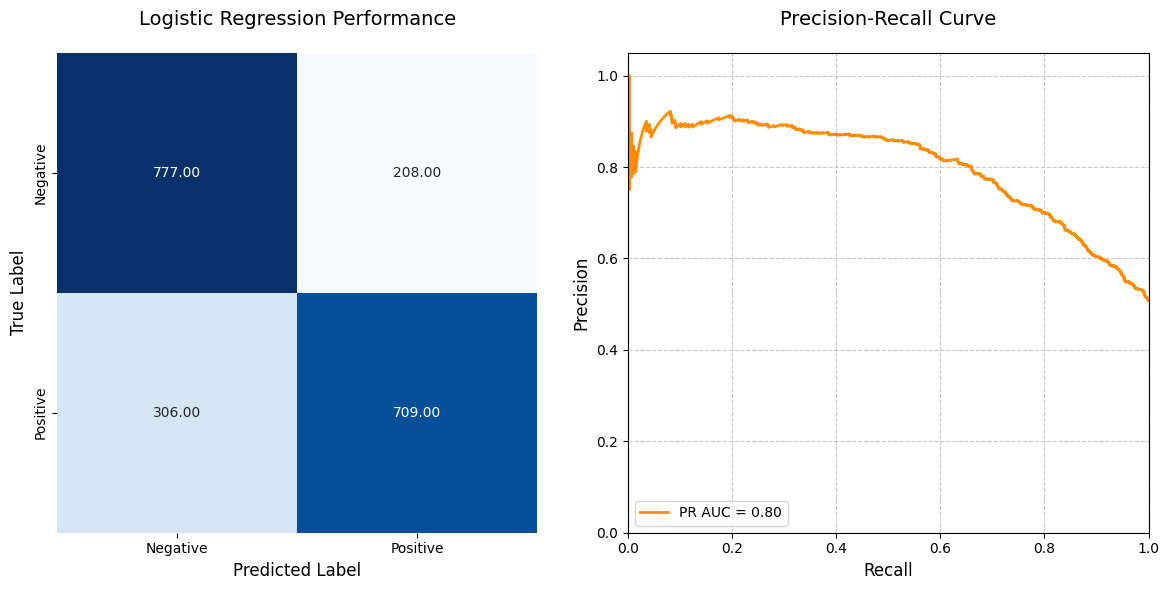

In [156]:
y_scores = rf_model.predict_proba(x_test)[:, 1]
plot_confusion_matrix(y_true=y_test, y_pred=rf_model.predict(x_test), y_scores=y_scores, 
                        classes=['Negative', 'Positive'], normalize=True, 
                        title='Logistic Regression Performance')

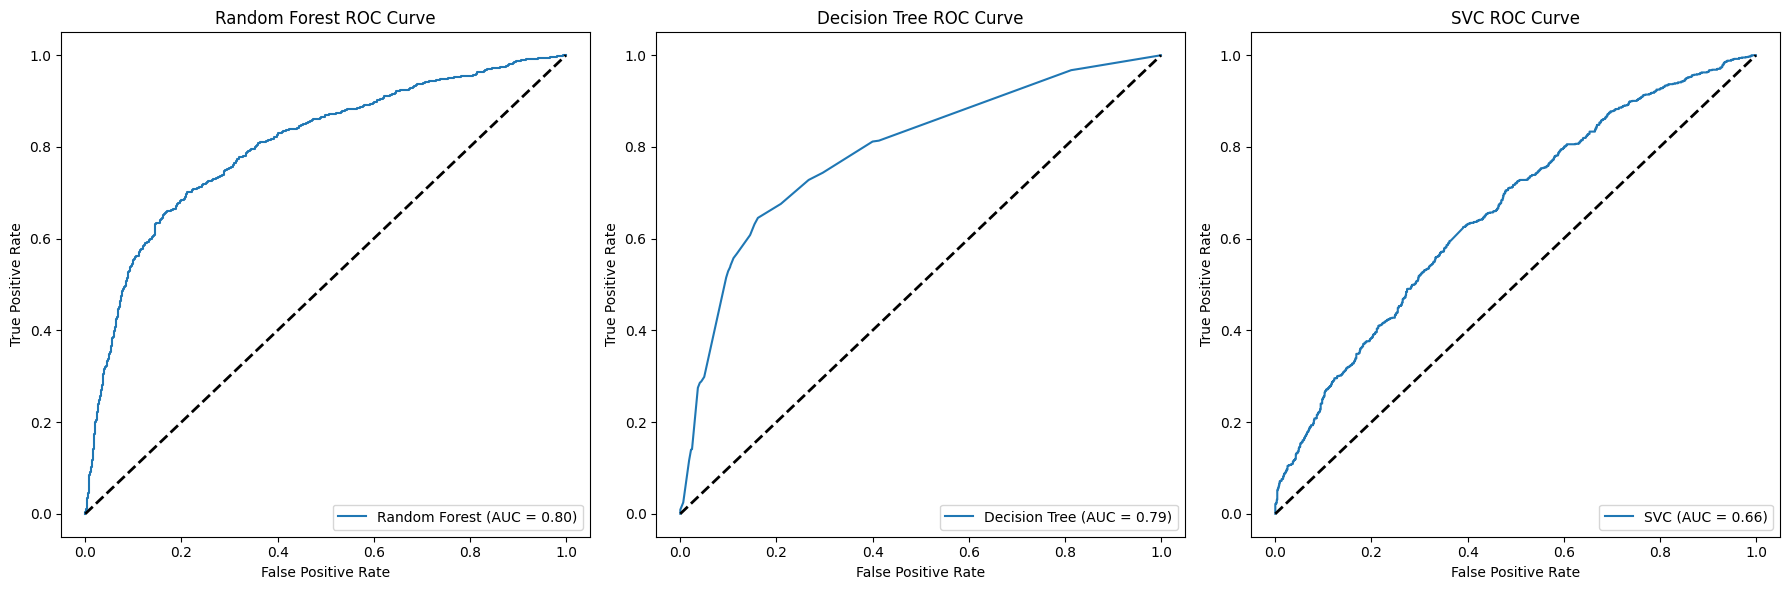

In [ ]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_true, y_scores, model_name, ax):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC)')
    ax.legend(loc='lower right')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_roc_curve(y_test, rf_model.predict_proba(x_test)[:, 1], 'Random Forest', axes[0])
axes[0].set_title('Random Forest ROC Curve')

plot_roc_curve(processed_y_test, dt_model.predict_proba(processed_x_test)[:, 1], 'Decision Tree', axes[1])
axes[1].set_title('Decision Tree ROC Curve')

plot_roc_curve(y_test, svc_model.predict_proba(x_test)[:, 1], 'SVC', axes[2])
axes[2].set_title('SVC ROC Curve')

plt.tight_layout()
plt.show()

